# Curve-Fitting

In [2]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure.
%matplotlib inline
import numpy as np

In [3]:
# OPTIONAL: Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

## Introduction

In this lab, we will introduce `SciPy`, the **Scientific Python** Library.

SciPy is a library of Python modules for scientific computing that provides more specific functionality than `NumPy`
For example, it contains modules for:

1. Special Functions 
2. Maximization, minimization, and curve-fitting of data 
3. Roots of algebraic and transcendental equations
4. Numerical Integration of functions and data
5. Numerical methods for the solution of Ordinary Differential Equations
6. etc.

Today, we will focus on the `scipy.optimize` submodule. It provides a range of popular algorithms for minimization of multidimensional functions (with or without additional constraints), least-squares data-fitting and multidimensional equation solving (root-finding).

`SciPy` general nonlinear least squares fitting routine is called `scipy.optimize.leastsq()`, which finds the most optimum values of the parameters to a theoretical function that approximates some data points. 

This 'fitting' of a function to data is performed using the **Levenberg-Marquardt Method** implemented by the MINPACK library developed by More, Sorensen, Hillstrom, and Garbow at the Argonne National Laboratory in the US, ([here is the minpack website](https://www.mcs.anl.gov/~more/ANL8074a.pdf)): given a set of empirical data-pairs $\left (x_i, y_i\right )$ of independent and dependent variables, this method finds the parameters $\vec{\beta} = \left(\beta_0, \beta_1, \beta_2, \dots\right)$ of the model curve $\mathbf f\left(\vec{x}, \vec{\beta}\right )$, so that the sum of the squares of the deviations is minimized.


The Levenberg-Marquardt algorithm works by using Linear Algebra Methods (which we'll discuss in later labs) to repeatedly solve the set of linear equations given by 
\begin{equation*}
\left (\mathbf J^{\mathrm T} \mathbf J + \lambda\mathbf I\right ) \cdot \vec{\delta} = \mathbf J^{\mathrm T}\cdot\left [\vec{y} - \mathbf f\left (\vec{x}, \vec{\beta}\right )\right]
\end{equation*}
Here, it is assumed that there is an initial "guess" for the parameters $\vec{\beta}$, and incrementing these guess values by $\vec{\delta}$ brings them closer to the best fitted parameters. The matrix $\mathbf J$ is the **Jacobian Matrix**, whose elements are given by
\begin{equation*}
\mathbf{J}_{ij} = \frac{\partial \mathbf f(y_i, \beta_j)}{\partial\beta_j}
\end{equation*}
Unless explicitly provided, these are computed using numerical approximation methods. **Note that** this is not a square matrix. For instance, if $\vec{y}$ is prepared from $N$ number of $(x_i, y_i)$ data points, and $\beta$ has only one parameter, then $\mathbf J$ is a $N\times 1$ matrix.

This system of linear equations is solved for each $\vec{\beta}$ to obtain the solution $\vec{\delta}$, then repeated by updating $\vec{\beta}\rightarrow\vec{\beta}+\vec{\delta}$ on the RHS. The value of the constant $\lambda$ (called the **damping factor**) is also updated using a more complex algorithm. These operations are done again and again until the iterative map converges up to a tolerance $\epsilon$, *i.e.*, when the norm $\vert\vert \vec{\delta}\vert\vert\leq\epsilon$. This ensures that the sum of squares, given by
\begin{equation*}
\chi^2(\vec{\beta})\equiv \left\vert\left\vert y_i - \mathbf f(x_i,\vec{\beta})\right\vert\right\vert^2,
\end{equation*}
reaches a minimum value. We will discuss this $\chi^2$ function in more detail below.

The `scipy.optimize.leastsq()` function implements this method. It has the most basic call signature:

```python
   parameters = scipy.optimize.leastsq(residuals, x0, args=(x,y)).
```

This will attempt to fit a sequence of data points, y, to a model function, `f()`, which must be known. The function depends on one or more fit parameters. The arguments required for `leastsq()` are, in the given order:

1. The name of a related function, say, `residuals()`, which returns the difference between y and f (the residuals). This must be provided by you. 

2. An initial 'guess' for the fitted parameters, stored in a tuple x0. 

3. A keyword argument `args=`. If `residuals()` requires any other arguments (typically arrays of the data x,y), pass them in the sequence args as a tuple.

This function, when executed, will return a tuple of the optimally fit parameters, which can be unpacked and applied to the model function `f()` to obtain the fitted data.

Let us look at an example. Suppose you are given experimental data from an oscillating pendulum: Pendulum length $L$ versus oscillation time-period $T$.

A sample dataset can be found in the data file located at the path

```bash
    data/pendulum_data.csv.
```

Part of the data is reproduced below:

| length(m) | time(sec)|
|-----------|----------|
| 1.00E-01  | 6.90E-01 |
| 1.10E-01  | 6.95E-01 |
| 1.20E-01  | 7.43E-01 |
| 1.30E-01  | 7.54E-01 |
| 1.40E-01  | 8.36E-01 |
|  ...      |   ...    |
|  ...      |   ...    |
|  ...      |   ...    |

Let us import it into a `NumPy` array using the `np.genfromtxt()` function and plot it using `matplotlib`.


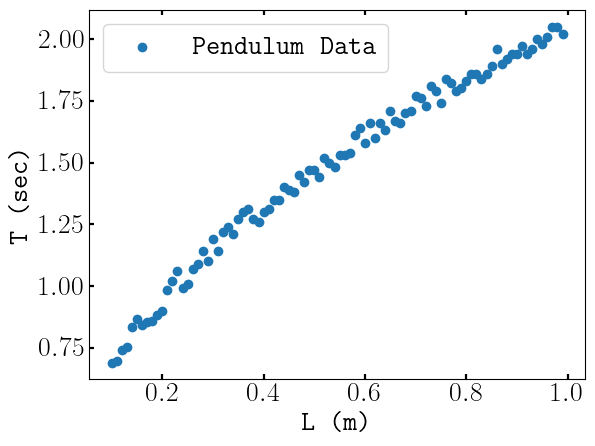

In [1]:
import numpy as np
import matplotlib.pyplot as plt
data = np.genfromtxt("data/pendulum_data.csv", delimiter=',', skip_header=1)
lengths = data[:,0]
times = data[:, 1]
plt.xlabel("L (m)")
plt.ylabel("T (sec)")
plt.scatter(lengths, times, label='Pendulum Data')
plt.legend()

As you can see, the data looks noisy. There are a lot of experimental errors.
Theoretically, we know that the formula linking them is 

\begin{equation*}
T = 2\pi\sqrt{\frac{L}{g}},
\end{equation*}

where $g$ is the acceleration due to gravity. If we invert this, then

\begin{equation*}
L = \frac{g}{4\pi^2}\; T^2.
\end{equation*}
The dependence is quadratic, inverting the $x$ and $y$ in the plot above yields

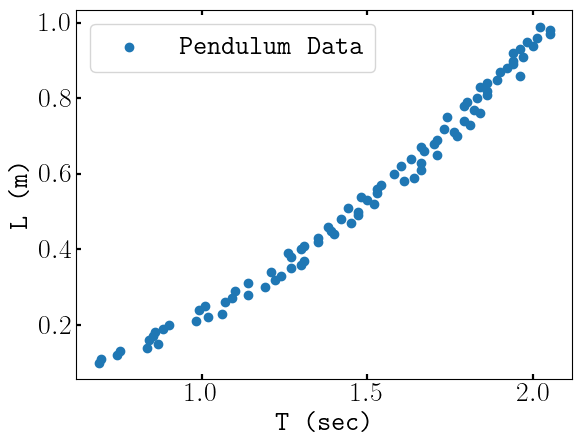

In [24]:
plt.xlabel("T (sec)")
plt.ylabel("L (m)")

plt.scatter(times, lengths, label='Pendulum Data')

plt.legend()

Although noisy, the data does roughly follow a parabolic rise, as expected from the theory.

Let us fit this formula to the data to estimate $g$. Thus, we need to code a function that has **one fit parameter**, $g$. 

We can choose our theoretical function to be either the original one or the inverted one. However, since most pendulum experiments involve controlling the length and measuring the period, it is appropriate to take the length $l$ as the independent variable and time period $T$ as the dependent variable, so let us stick to the original formula. 

First, we need to define our theoretical function `f()`:
* The function `f()` (you can use any name that you like) can have the first argument as the parameter(s). Here, that is $g$.

* The last argument should therefore be the independent variable. here, it is the length of the pendulum $l$.

In [26]:
def f(g, l):
    return 2 * np.pi * np.sqrt(l/g)

Next, prepare a residual function. This outputs the difference between the data and the theoretical function `f()`

* The first arguments **must be** the sequence of parameters, packaged as a tuple. Since we only have one parameter $g$, we need not bother with tupling, and just pass $g$ as the first argument

* After these, the additional arguments needed are the data for the independent variable  (in this case, l), and the dependent variable, in this case, $T$. 

In [27]:
def residuals(g, l, T):
    return T - f(g, l)

Next, let us make some initial guesses for the parameters that aren’t too wildly off and call `leastsq()`

In [28]:
from scipy.optimize import leastsq
g = 10
glsq = leastsq(residuals, g, args=(lengths, times))
glsq

(array([9.23314861]), 3)

Note that `leastsq` returned a tuple. The first value is an array of the fitted parameters, the second is a Jacobian approximation to the Hessian of the least squares objective function. It provides a measure of how accurate the fitting is. Let us now plot the theoretical function with the fitted parameter alongside the data points.

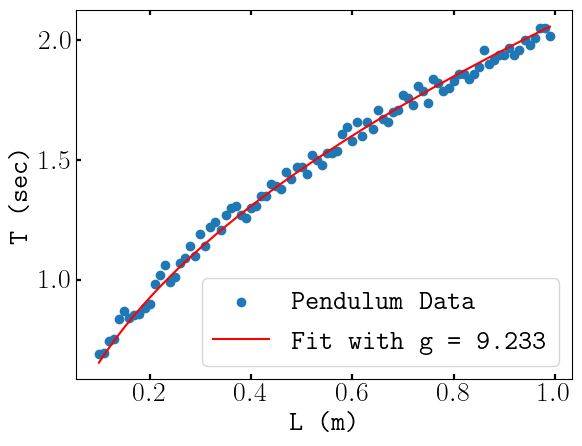

In [29]:
plt.xlabel("L (m)")
plt.ylabel("T (sec)")
plt.scatter(lengths, times, label="Pendulum Data")

params = glsq[0] #The array of fitted parameters is the first element of the tuple
g_fit = params[0] # There is only one fit parameter, g.


#Lets take lots of points for the fitted function so it appears nice and continuous
l0, l1 = lengths[0], lengths[-1]
l_vals = np.linspace(l0, l1, 1000)

plt.plot(l_vals,f(g_fit, l_vals), color='red', label=f'Fit with g = {g_fit:1.3f}')
plt.legend()

Let is now try a multi-parameter fit to an exponential decay. Just for variety, let us create some fake data for an exponential decay of the type $y = y_0 e^{-t/\tau}$ that has noise in it. This is our 'experimental data'. Let us choose the amplitude $y_0=10$ and decay rate $\tau=0.5$ to generate our data.

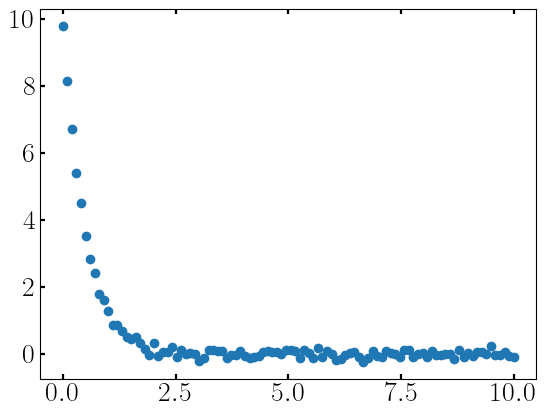

In [30]:
times = np.linspace(0, 10, 100)
amplitude = 10 * np.exp(-times/0.5) 

#Some random numbers as noise
noise = 0.1 *  np.random.randn(len(times))

t = times
y = amplitude + noise
plt.scatter(t, y)

Now, we will fit it to exponential decay. The procedure is just like before, except now there are **two** fitting parameters: The amplitude $y_0$, and the decay rate $\tau$.

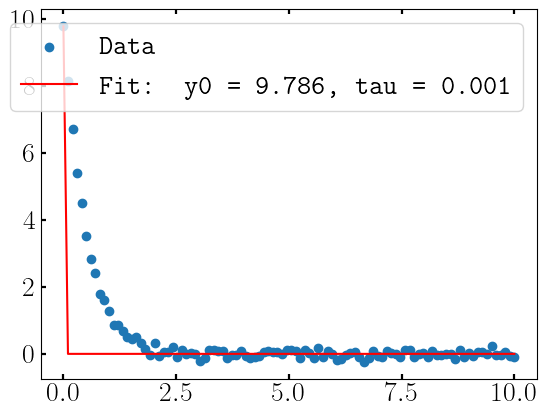

In [31]:
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

#The parameters can be in any order, but the order is kept fixed always
def residuals(params, t, y):
    y0, tau = params
    experimental = y
    theoretical = y0 * np.exp(-t/tau)
    return experimental - theoretical

#The order must be the same as in the residuals definition above
#This is a bad guess
params_guess = (100, 0.001)

params_fit = leastsq(residuals, params_guess, args=(t, y))

y0_fit, tau_fit = params_fit[0]

plt.scatter(t,y, label='Data')
plt.plot(t, y0_fit* np.exp(-t/tau_fit),color='red', label=f'Fit: y0 = {y0_fit:2.3f}, tau = {tau_fit:1.3f}')
plt.legend()


As you can see, the fit is not very good. The closer our initial guess is to the true values of the fit parameters, the better the fit will be

Thus, fitting can be improved by making better guesses of the parameters, followed by visual inspection of the plots. Here, clearly the guess for the decay rate was too rapid, so let's choose a slower rate.

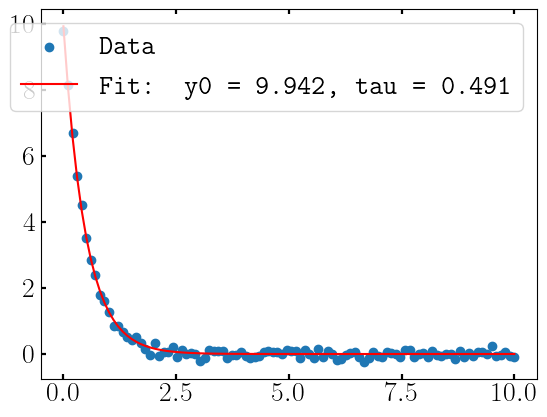

In [32]:
params_guess = (100, 0.1)

params_fit = leastsq(residuals, params_guess, args=(t, y))

y0_fit, tau_fit = params_fit[0]

plt.scatter(t,y, label='Data')
plt.plot(t, y0_fit* np.exp(-t/tau_fit),color='red', label=f'Fit: y0 = {y0_fit:2.3f}, tau = {tau_fit:1.3f}')
plt.legend()

### Exercise 01:

Redo the example above, except take the logarithm of the experimental $y$-data and fit it to a ***linear*** function $y = mx+b$. Plot the new experimental data as well as the fitted function with appropriate legend and labels.

### Exercise 02:

Write a program that fits the Lorentzian line shape function centered at $x_0$ with half width at half-maximum (HWHM), $\gamma$ , amplitude, $A$:

\begin{equation*}
y = \frac{A\gamma^2}{\gamma^2 + \left(x-x_0\right)^2}
\end{equation*}

The sample data is provided in the file located at:

```bash
    data/peak_data.csv
```

### Exercise 03:


The temperature extremes in the American state of Alaska for each month, starting in January, are given by (in degrees Celsius):

| max: | 17, | 19, | 21, | 28, | 33, | 38, | 37, | 37, | 31, | 23, | 19, | 18 |
|------|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|----|
| min: | -62,| -59,| -56,| -46,| -32,| -18,| -9, | -13,| -25,| -46,| -52,| -58|

1. Plot these temperature extremes against time.
2. Define a function that can describe min and max temperatures. Hint: this function has to have a period of 1 year. Hint: include a time offset. Fit this function to the data and plot the result.

## Hypothesis Testing

So far, we have seen how to find optimum values of the fit parameters by trial and error, where error involves visually inspecting the fitted plots and contrasting it with the experimental data. 

There is a more quantitative way to do this. If the experimental data points (given) are $y_i$ and the theoretical data poins are calculated from $f(x_i, \mathbf{\beta})$, then the relative error for each evaluation is

\begin{equation*}
\epsilon_i \equiv \frac{y_i - f(x_i, \beta)}{f(x_i, \beta)}
\end{equation*}

The MINPACK algorithm described in the previous section find the values of the parameter(s) $beta$ that minimize the $\chi^2$ of these errors. That is to say, it minimizes

\begin{align*}
\chi^2\big(\beta\big) &\equiv \sum_i \left\vert \epsilon_i \right\vert^2 \\
              &= \sum_i  \left\vert \frac{y_i - f(x_i, \beta)}{f(x_i, \beta)} \right\vert^2.
\end{align*}

This is done by estimating the roots of the functions given by $\partial\chi^2/\partial\beta$. You can therefore calculate the $\chi^2$ as an explicit **hypothesis test**, where your hypothesis is the choice of your function, together with the initial guesses for the parameters. The smaller your value of $\chi^2$, the better your hypothesis. In the limit that $\chi^2$ vanishes, each $\epsilon_i$ vanishes and your hypothesis is exactly accurate.

Let us check this for the first example involving the pendulum data.


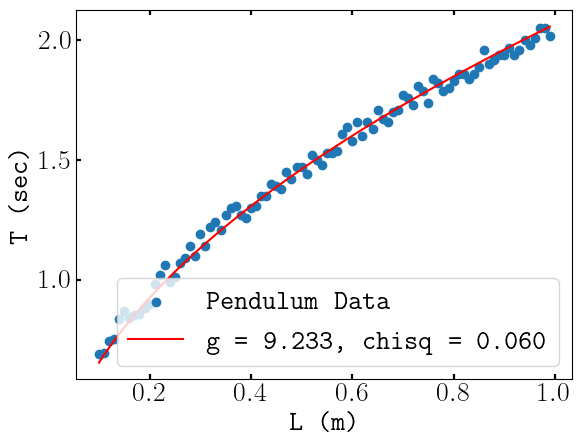

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

def f(g, l):
    return 2 * np.pi * np.sqrt(l/g)

def residuals(g, l, T):
    return T - f(g, l)

data = np.genfromtxt("data/pendulum_data.csv", delimiter=',', skip_header=1)
lengths = data[:,0]
times = data[:, 1]

plt.xlabel("L (m)")
plt.ylabel("T (sec)")

plt.scatter(lengths, times, label="Pendulum Data")

g = 10. # Good guess
# g = 1.  # Bad guess

glsq = leastsq(residuals, g, args=(lengths, times))
params = glsq[0] 
g_fit = params[0] 

l0, l1 = lengths[0], lengths[-1]
l_vals = np.linspace(l0, l1, 1000)

#Now, let us compute chi-square
expt_data = times
theoretical_data = np.array([f(g_fit, l) for l in lengths])

epsilon_data = (expt_data-theoretical_data)/theoretical_data
chisq = np.sum(np.abs(epsilon_data)**2)

plt.plot(l_vals,f(g_fit, l_vals), color='red', label=f'g = {g_fit:1.3f}, chisq = {chisq:1.3f}')
plt.legend()


If we run the hypothesis test with both a good and bad guess for $g$, we get a pretty low $\chi^2$. This shows that our hypothesis is strong. As an experimental control, let us choose a ***bad hypothesis***, where our formula is given by

\begin{equation*}
T = \alpha L^{3/2}
\end{equation*}

Let us fit this and check the new $\chi^2$.

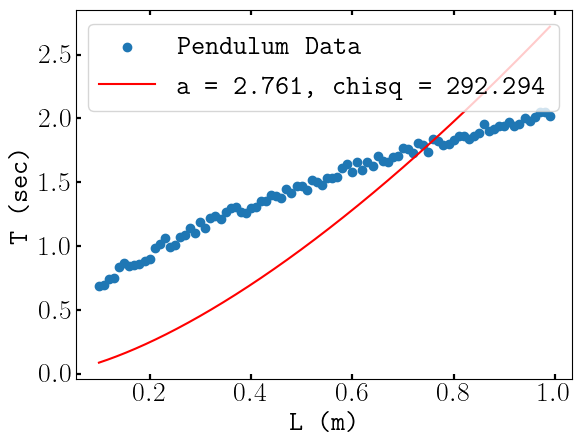

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq


def residuals(a, l, T):
    return T - (a * l**(3/2))

data = np.genfromtxt("data/pendulum_data.csv", delimiter=',', skip_header=1)
lengths = data[:,0]
times = data[:, 1]

plt.xlabel("L (m)")
plt.ylabel("T (sec)")

plt.scatter(lengths, times, label="Pendulum Data")


a = 1. #A guess

alsq = leastsq(residuals, a, args=(lengths, times))
params = alsq[0] 
a_fit = params[0] 

l0, l1 = lengths[0], lengths[-1]
l_vals = np.linspace(l0, l1, 1000)

#Now, let us compute chi-square
expt_data = times
theoretical_data = np.array([a_fit * l**(3/2) for l in lengths])

epsilon_data = (expt_data-theoretical_data)/theoretical_data
chisq = np.sum(np.abs(epsilon_data)**2)

theoretical_plot = np.array([a_fit * l**(3/2) for l in l_vals])
plt.plot(l_vals,theoretical_plot, color='red', label=f'a = {a_fit:1.3f}, chisq = {chisq:1.3f}')

plt.legend()

As you can see, the fitting is  pretty bad, and the $\chi^2$ is high. Thus, the hypothesis tests poorly.

### Exercise 04:

Fit the data from exercise 03 to the lorentzian function from exercise 02 and check if that is a better hypothesis than the one that you had chosen for exercise 03. 